# Scales and Models for Feedback Bubbles

In this notebook we will provide definitions and discussions of the relevant physical scales for different feedback mechanisms due to massive stars in star-forming regions. These scales are written out as code in `quantities.py` using `astropy.units` and we will call on these to make some comparison plots.

We also have implemented several models for the evolution of feedback bubbles (FBs) from this feedback, contained within `fb_models.py` which will also be explained here.

In [1]:
# some libraries we will need
import numpy as np
import matplotlib.pyplot as plt

import astropy.units as u
import astropy.constants as ac

import quantities
import sfe_prescriptions as sfes
import fb_models

from scipy.optimize import brentq

In [9]:
nbar = 100*u.cm**-3
rhobar = 1.4*ac.m_p*nbar
appdot = 1e5*u.Msun*u.km/u.s/u.Myr
Lwind = 1e37*u.erg/u.s
Qo = 1e50/u.s

model1 = fb_models.MD_CEM(rho0=rhobar, Q0=Qo, pdotw=appdot)
model2 = fb_models.ED_CEM(rho0=rhobar, Q0=Qo, Lwind=Lwind)

In [10]:
model1.zeta, model2.zeta

(np.float64(0.7417931104627451), np.float64(2.049627734280892))

Text(0, 0.5, '$\\mathcal{R}\\,\\, [{\\rm pc}]$')

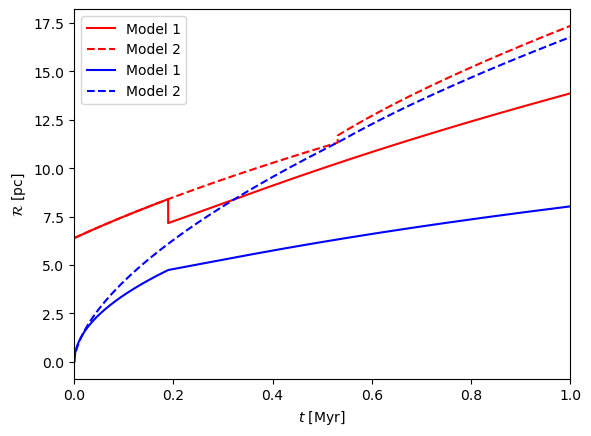

In [11]:
tlin = np.linspace(0, 1, 10000)*u.Myr

plt.plot(tlin, model1.radius(tlin), 'r',label='Model 1')
plt.plot(tlin, model2.radius(tlin), 'r--',label='Model 2')

plt.plot(tlin, model1.wind_radius(tlin), 'b',label='Model 1')
plt.plot(tlin, model2.wind_radius(tlin), 'b--',label='Model 2')

plt.xlim(0,1)
plt.legend()
plt.xlabel(r'$t\,\, [{\rm Myr}]$')
plt.ylabel(r'$\mathcal{R}\,\, [{\rm pc}]$')

# Photo-Ionized Gas

The radius of a bubble of gas of uniform density that is ionized by a central source is given by the Strömgren radius as

$R_{\rm St} \equiv \left(\frac{3 Q_0}{4\pi \overline{n}_{\rm H}^2 \alpha_B} \right)^{1/3} = 6.39 \, {\rm pc} 
    \left( \frac{Q_0}{10^{50}\, {\rm s}^{-1}}\right)^{1/3}
    \left(\frac{\overline{n}_{\rm H}}{100\, {\rm cm}^{-3}} \right)^{-2/3}$

where $Q_0$ is the ionizing photo rate, $\overline{n}_{\rm H}$ is the mean density of Hydrogen nuclei in the medium, and $\alpha_B$ is the so called "case B" recombination rate, which we have taken to be $3.11 \times 10^{-13}\, {\rm cm^3}\, {\rm s}^{-1}$ the vale of which is taken from Glover et al. 2010 for gas at a temperature of $T = 8000\, {\rm K}$.

We can calculate the above using the definition of this radius in `quantities.py` as

In [2]:
quantities.RSt(1e50/u.s, 100/(u.cm**3))

<Quantity 6.39292764 pc>

This bubble of ionized gas is established on the time-scale it takes to emit enough photons to ionize the whole region

$\tau_i \equiv \overline{n}_{\rm H}\frac{4\pi}{3Q_0}R_{\rm St}^3 = \left(\overline{n}_{\rm H}\alpha_B \right)^{-1}
        = 1.02 \times 10^3 \, {\rm yrs} \left(\frac{\overline{n}_{\rm H}}{100\, {\rm cm}^{-3}} \right)^{-1}$

Notice that this is the same time scale that it would take this volume to recombine, which comes from the fact that the volume is defined by ionization-recombination equilibirum. We can calculte the above as

In [3]:
quantities.Tion(100/(u.cm**3)).to(u.yr)

<Quantity 1018.90957601 yr>

Once the Strömgren Sphere is established, in an "R-type" fashion, the photo-ionized gas bubble expands dynamically in a "D-type" fashion following the Spitzer-like solution of Hoskawa & Inutsuka of

$R_{\rm Sp}= R_{\rm St}\left(1 + \frac{7}{4} \frac{t}{t_{d,i,0}} \right)^{4/7}$

where in the above, the D-type expansion is understood to begin at $t=0$. In the above the initial dynamical expansion time of the bubble is given as 

$t_{d,i,0} \equiv \frac{R_{\rm Sp}(t=0)}{\dot{R}_{\rm Sp}(t=0)} = \frac{\sqrt{3}}{2}\frac{R_{\rm St}}{c_i}
    = 5.41 \times 10^5\, {\rm yr} \, \left( \frac{Q_0}{10^{50}\, {\rm erg/s}}\right)^{1/3} \left(\frac{\overline{n}_{\rm H}}{100\, {\rm cm}^{-3}} \right)^{-2/3}
    \left( \frac{c_i}{10\, {\rm km/s}}\right)^{-1}$

we can calculate the above as.


In [4]:
quantities.Tdion(1e50/u.s, 100/(u.cm**3))

<Quantity 0.54134858 Myr>

# Wind Bubbles

Wind bubbles are characterized by a wind mass-loss rate $\dot{M}_w$ and wind velocity $V_{w}$, which jointly determine the mechanical luminosity of the wind $L_w = \frac{1}{2}\dot{M}_w V_w^2$. Bubbles blown by these winds have a few different stages. They first expand ballisitically, sweeping up the surrounding gas until the inertia of the swept-up material is comparable to the inertia of the wind. This occurs at a "shock radius"

$R_{w, {\rm shock}} = \sqrt{\frac{\dot{M}_w}{4\pi \overline{\rho} V_w}}
                    = 2.29 \times 10^{-2}\, {\rm pc} \left(\frac{\dot{M}_w}{100 \, M_{\odot}\, {\rm Myr}^{-1}} \right)^{1/2}
                    \left( \frac{\overline{n}_{\rm H}}{100\, {\rm cm}^{-3}}\right)^{-1/2} \left( \frac{V_w}{3000\, {\rm km/s}}\right)^{-1/2}$

this occurs at the shock time

$t_{w, {\rm shock}} = \sqrt{\frac{\dot{M}_w}{4\pi \overline{\rho} V_w^3}}
                    = 1.06 \times 10^{-5}\, {\rm Myr} \left(\frac{\dot{M}_w}{100 \, M_{\odot}\, {\rm Myr}^{-1}} \right)^{1/2}
                    \left( \frac{\overline{n}_{\rm H}}{100\, {\rm cm}^{-3}}\right)^{-1/2} \left( \frac{V_w}{3000\, {\rm km/s}}\right)^{-3/2}$

we can calculate these as

In [14]:
quantities.Rwshock(1e2*u.Msun/u.Myr, 100*aconsts.m_p/(u.cm**3), 3e3*u.km/u.s)

<Quantity 0.0323956 pc>

In [15]:
quantities.Twshock(1e2*u.Msun/u.Myr, 100*aconsts.m_p/(u.cm**3), 3e3*u.km/u.s).to(u.yr)

<Quantity 10.5587206 yr>

As one can readily see, this happens at an extremely small length scale and at an extremely early time for typical parameters. This makes this earliest phase pretty much irrelevant for any dynamical evolution of the wind-blown bubble. As the name suggests, after this point the wind interior can no longer expand at the wind velocity, at which point it shocks. At this point it follows a self-similar solution given by Section II of Weaver et al. (1977) until the outer shell is able to cool and form a thin-shell. This occurs at the shell-cooling time which is roughly defined by the time at which the age of the system is comparable to the cooling time of gas in the shell 

$t_{\rm sh, cool} = \frac{3 n_{\rm H}k_BT}{n_e^2 \Lambda(T)}$

where $\Lambda(T)$ is the cooling function, assumed to only be a function of temperature over the parameter regime of interest. In the above we have assumed the gas is fully ionized and therefore $n = 2n_{\rm H}$ and $n_{\rm H} = n_e$ with negligible contribution from the metals in the number density or electron density. 